# 2022. 08. 02.
# Tunnel hold and I(V) measurements

## Info:
- Setup: MCBJ (UFO)
- Sample: AU (new sample from Merck, opened:)
- Temperature, pressure: room, ambient
- Amplifier: Femto, 1e7
- bias offset = 0.005 V
- R_serial = 100k Ohm
- current offset = 76.2742 pA



|  Start  |   End  |Number of traces| Rate | Pull hold | Push hold |                        Notes                        |
|---------|--------|----------------|------|-----------|-----------|-----------------------------------------------------|
|  40401  | 43700  |      3300      | 0.5  |    1e-2   |    1e-3   |             constant_waveform_100_mv.ini            |
|  47601  | 51600  |      4000      | 0.5  |    1e-2   |    1e-3   |             constant_waveform_100_mv.ini            |
|  70201  | 73500  |      3300      | 0.5  |    1e-2   |    1e-3   | custom_IV_mcbj_with_wait_with_lot_of_bias_steps.ini |
|  77001  | 81500  |      4500      | 0.5  |    1e-2   |    1e-4   | custom_IV_mcbj_with_wait_with_lot_of_bias_steps.ini |
|  81501  | 96200  |     14700      | 0.5  |    1e-2   |    5e-4   | custom_IV_mcbj_with_wait_with_lot_of_bias_steps.ini |

**Important**: Issues with *dz_pull* for traces 40401, 47601, 70101, 77001. It's best to skip these traces

In [1]:
# imports
from mcbj import *
from tqdm.notebook import tqdm
import filter_traces
import plots
import pandas as pd
from matplotlib import rcParams
from pathlib import Path
date = "22_08_02"
sample_rate = 50_000
home_folder = Path(f"D:/BJ_Data/{date}")
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
from os import rename
import utils

In [2]:
def calc_2d_relax_hist(traces, home_folder,
                       bias_offset=0, min_step_len=100,
                       xrange = (0, 3), yrange = (1e-2, 100),
                       x_numbins = 15_000, y_numbins_per_decade = 100):
    
    count = 0
    xbins = np.linspace(xrange[0], xrange[1], num=x_numbins)
    
    num_of_decs = np.log10(yrange[1]) - np.log10(yrange[0])
    ybins = np.logspace(np.log10(yrange[0]), np.log10(yrange[1]),
                        num=int(y_numbins_per_decade * num_of_decs), base=10)
    
    for trace in tqdm(traces, desc='Calculating 2D stability histograms'):
        trace_pair = TracePair(trace, load_from=home_folder)
        hold_trace = HoldTrace(trace, load_from=home_folder,
                               bias_offset=bias_offset, r_serial_ohm=trace_pair.R_serial,
                               sample_rate=trace_pair.sample_rate, min_step_len=min_step_len)
    
        h, xedges, yedges = np.histogram2d(hold_trace.time_axis_pull,
                                           hold_trace.hold_conductance_pull/hold_trace.hold_conductance_pull[-1],
                                           bins=[xbins, ybins])
        x_mesh, y_mesh = np.meshgrid(xedges, yedges)

        if 'H_pull' in locals():
            H_pull += h.T
        else:
            H_pull = h.T

        h, xedges, yedges = np.histogram2d(hold_trace.time_axis_push,
                                           hold_trace.hold_conductance_push/hold_trace.hold_conductance_push[-1],
                                           bins=[xbins, ybins])
        x_mesh, y_mesh = np.meshgrid(xedges, yedges)

        if 'H_push' in locals():
            H_push += h.T
        else:
            H_push = h.T

        count += 1

    print(f'Histograms created from {count} traces.')
    
    return x_mesh, y_mesh, H_pull, H_push
    

In [3]:
def plot_2d_relax_hist(x_mesh, y_mesh, H_pull, H_push,
                       at_index: Optional[Union[int, Tuple[int, ...]]] = None):
       
    fig = plt.figure(figsize=utils.point2inch(240, 240), dpi=300)  # figsize: (width, height) in inches
    gs_total = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=(1, 1), width_ratios=(2, 1),
                                 figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.2, wspace=0, hspace=0)

    ax_relax_pull = fig.add_subplot(gs_total[0, 0])
    ax_relax_push = fig.add_subplot(gs_total[1, 0])
    ax_hist_pull = fig.add_subplot(gs_total[0, 1])
    ax_hist_push = fig.add_subplot(gs_total[1, 1])

    ax_relax_pull.xaxis.tick_top()
    ax_relax_pull.xaxis.set_label_position('top')
    ax_relax_pull.xaxis.set_ticks_position('both')
    ax_relax_pull.yaxis.set_ticks_position('both')

    ax_relax_push.xaxis.set_ticks_position('both')
    ax_relax_push.yaxis.set_ticks_position('both')

    ax_hist_pull.xaxis.tick_top()
    ax_hist_pull.xaxis.set_label_position('top')
    ax_hist_pull.yaxis.tick_right()
    ax_hist_pull.yaxis.set_label_position('right')
    ax_hist_pull.xaxis.set_ticks_position('both')
    ax_hist_pull.yaxis.set_ticks_position('both')

    ax_hist_push.yaxis.tick_right()
    ax_hist_push.yaxis.set_label_position('right')
    ax_hist_push.xaxis.set_ticks_position('both')
    ax_hist_push.yaxis.set_ticks_position('both')

    ax_relax_pull.set_yscale('log')
    ax_relax_push.set_yscale('log')
    ax_relax_pull.axhline(2, lw=0.5, ls='--', c='k')
    ax_relax_pull.axhline(0.5, lw=0.5, ls='--', c='k')
    ax_relax_push.axhline(2, lw=0.5, ls='--', c='k')
    ax_relax_push.axhline(0.5, lw=0.5, ls='--', c='k')
    im_norm_pull = ax_relax_pull.pcolormesh(x_mesh, y_mesh, H_pull, cmap=utils.cmap_geo32, vmax=2000)
    im_norm_push = ax_relax_push.pcolormesh(x_mesh, y_mesh, H_push, cmap=utils.cmap_geo32, vmax=2000)
    
    if at_index is not None:
        if isinstance(at_index, int):
            at_index=tuple(at_index)
            
        for i, ind in enumerate(at_index):
            ax_relax_pull.axvline(x_mesh[0, ind], ls='--', lw=0.5, c=utils.blues[i])
            ax_relax_push.axvline(x_mesh[0, ind], ls='--', lw=0.5, c=utils.reds[i])
            ax_hist_pull.plot(H_pull[:, ind], np.mean(np.vstack((y_mesh[:-1, ind], y_mesh[1:, ind])), axis=0), c=utils.blues[i], lw=0.5)
            ax_hist_push.plot(H_push[:, ind], np.mean(np.vstack((y_mesh[:-1, ind], y_mesh[1:, ind])), axis=0), c=utils.reds[i], lw=0.5)
    ax_hist_pull.set_yscale('log')
    ax_hist_pull.set_xlim(left=0)
    ax_hist_push.set_yscale('log')
    ax_hist_push.set_xlim(left=0)
    
    ax_relax_pull.set_ylim(1e-2, 1e2)
    ax_relax_push.set_ylim(1e-2, 1e2)
    ax_hist_pull.set_ylim(1e-2, 1e2)
    ax_hist_push.set_ylim(1e-2, 1e2)
    
    ax_relax_pull.set_xlabel('Time [s]')
    ax_relax_push.set_xlabel('Time [s]')
    ax_hist_pull.set_xlabel('Counts')
    ax_hist_push.set_xlabel('Counts')
    
    ax_relax_pull.set_ylabel('Scaled conductance [a.u.]')
    ax_relax_push.set_ylabel('Scaled conductance [a.u.]')
    ax_hist_pull.set_ylabel('Scaled conductance [a.u.]')
    ax_hist_push.set_ylabel('Scaled conductance [a.u.]')
    
    return ax_relax_pull, ax_relax_push, ax_hist_pull, ax_hist_push

## Hold measurements for stability

In [4]:
trace_num = 40404
trace_pair = TracePair(trace_num, load_from=home_folder)
hold_trace = HoldTrace(trace_num, load_from=home_folder, bias_offset=0, r_serial_ohm=trace_pair.R_serial,
                       sample_rate=trace_pair.sample_rate, min_step_len=100)

In [5]:
hold_trace.analyse_hold_trace(num_of_fft=1, subtract_bg=False, freq_range=(100, 1000))

(<AxesSubplot:ylabel='Piezo [V]'>,
 <AxesSubplot:ylabel='G [$G_{0}$]'>,
 <AxesSubplot:ylabel='Piezo [V]'>,
 <AxesSubplot:ylabel='G [$G_{0}$]'>)

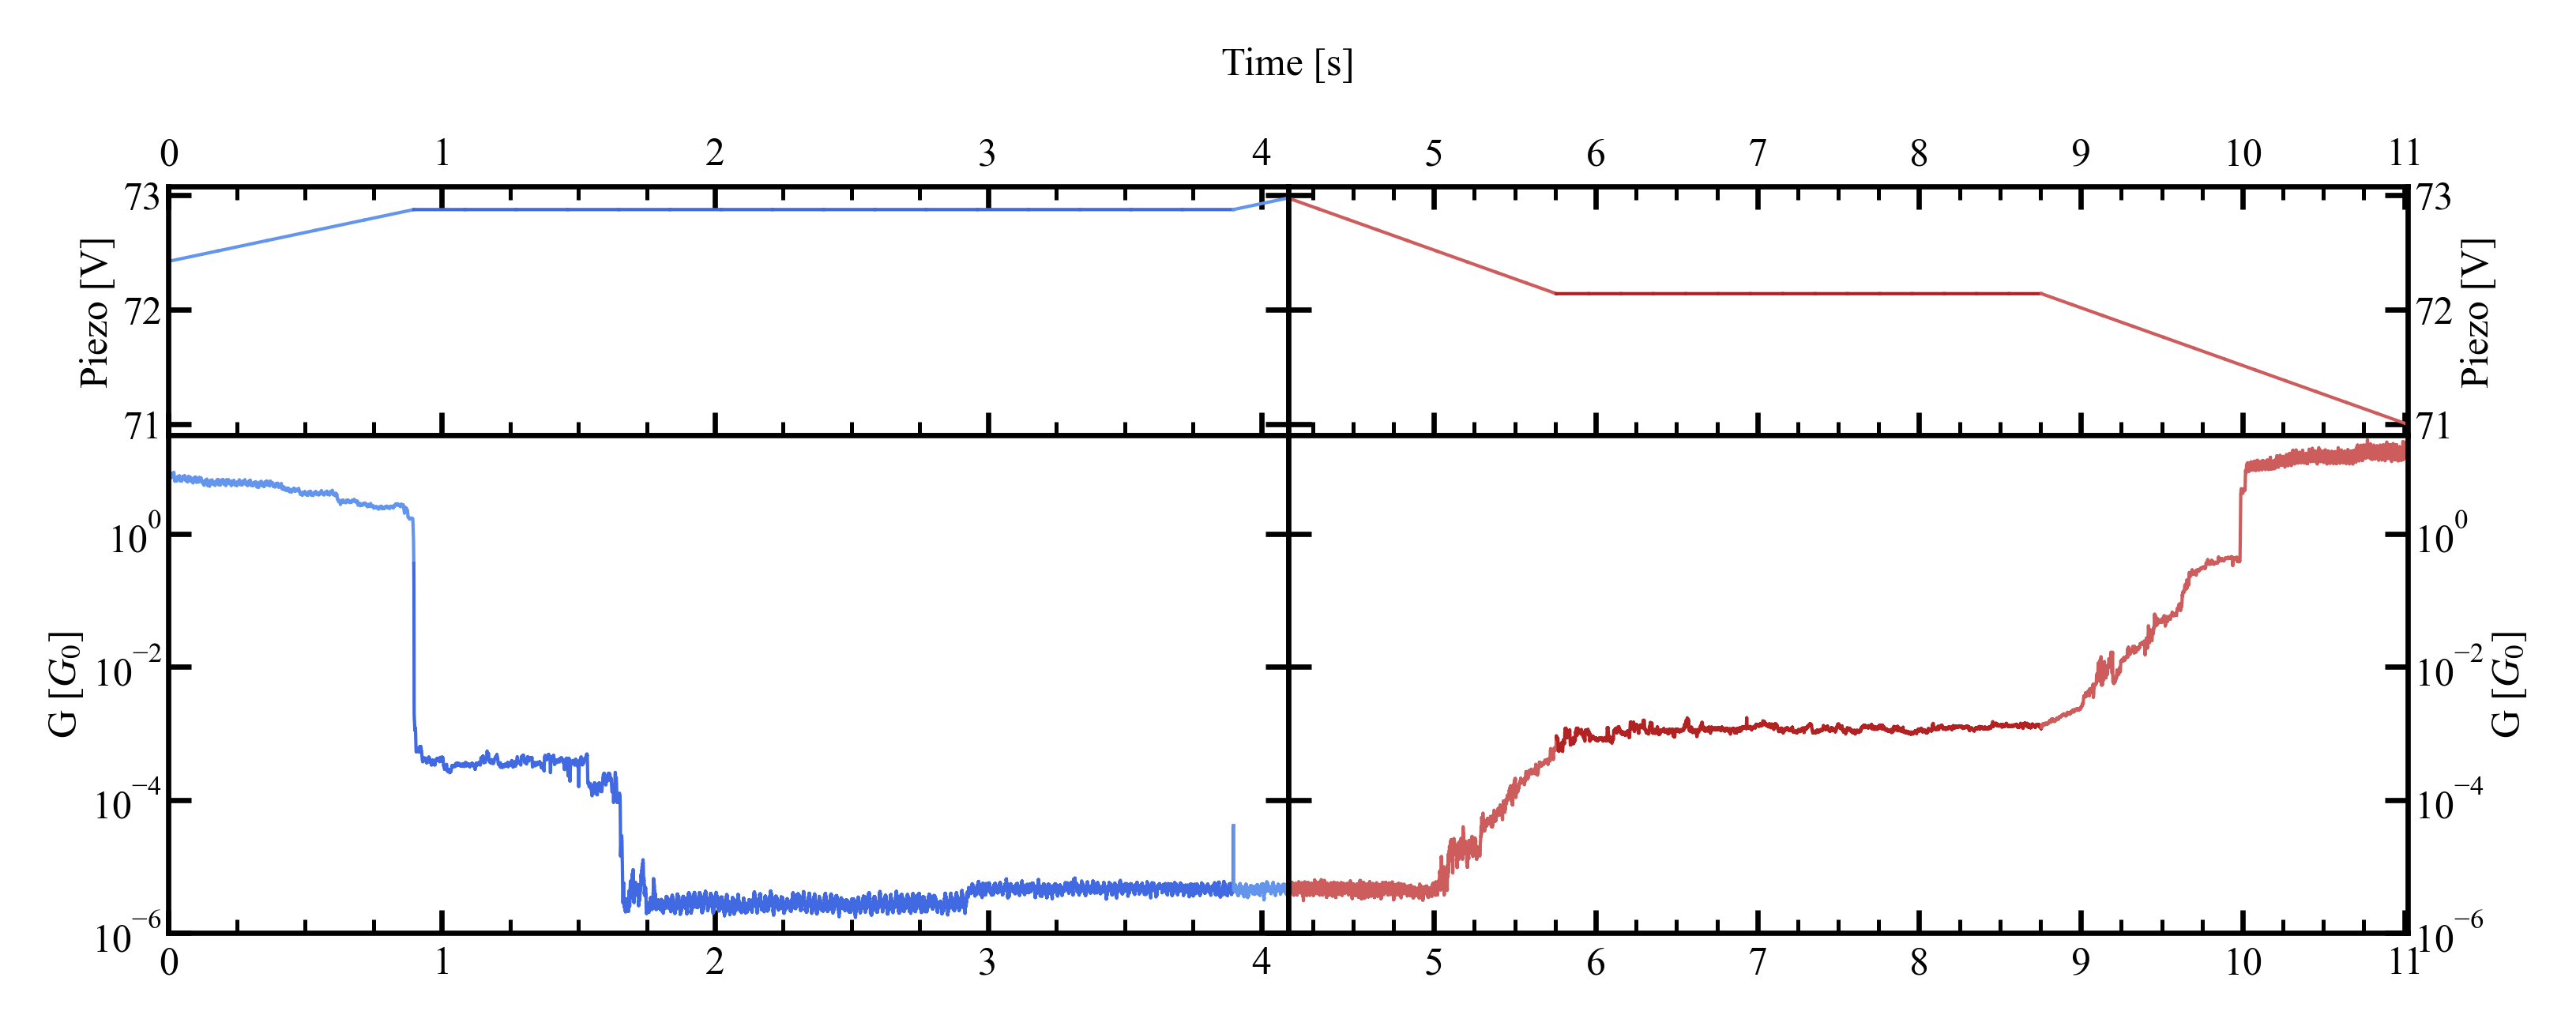

In [6]:
plots.plot_measurement_scheme_combed_both(trace_pair=trace_pair,
                                          hold_trace=hold_trace,
                                          home_folder=home_folder,
                                          smoothing=100)

###  40402-43700 Filter traces that did not break

In [7]:
filt_pull, filt_push = filter_traces.filter_hold(folder=home_folder,
                                                 filter_condition=filter_traces.does_not_break_array,
                                                 start_trace=40402, end_trace=43700,
                                                 bias_offset=0,
                                                 r_serial_ohm=trace_pair.R_serial,
                                                 min_step_len=100, iv=None)

filt_both = np.intersect1d(filt_pull, filt_push)

  0%|          | 0/3299 [00:00<?, ?it/s]

In [8]:
print('pull:', filt_pull.shape[0])
print('push:', filt_push.shape[0])
print('both:', filt_both.shape[0])

pull: 1738
push: 3288
both: 1730


In [9]:
trace_num = np.random.choice(filt_both)
print(trace_num)

43552


In [10]:
trace_pair = TracePair(trace_num, load_from=home_folder)
hold_trace = HoldTrace(trace_num, load_from=home_folder, bias_offset=0, r_serial_ohm=trace_pair.R_serial,
                       sample_rate=trace_pair.sample_rate, min_step_len=100)
hold_trace.analyse_hold_trace(num_of_fft=1, subtract_bg=False, freq_range=(100, 1000))

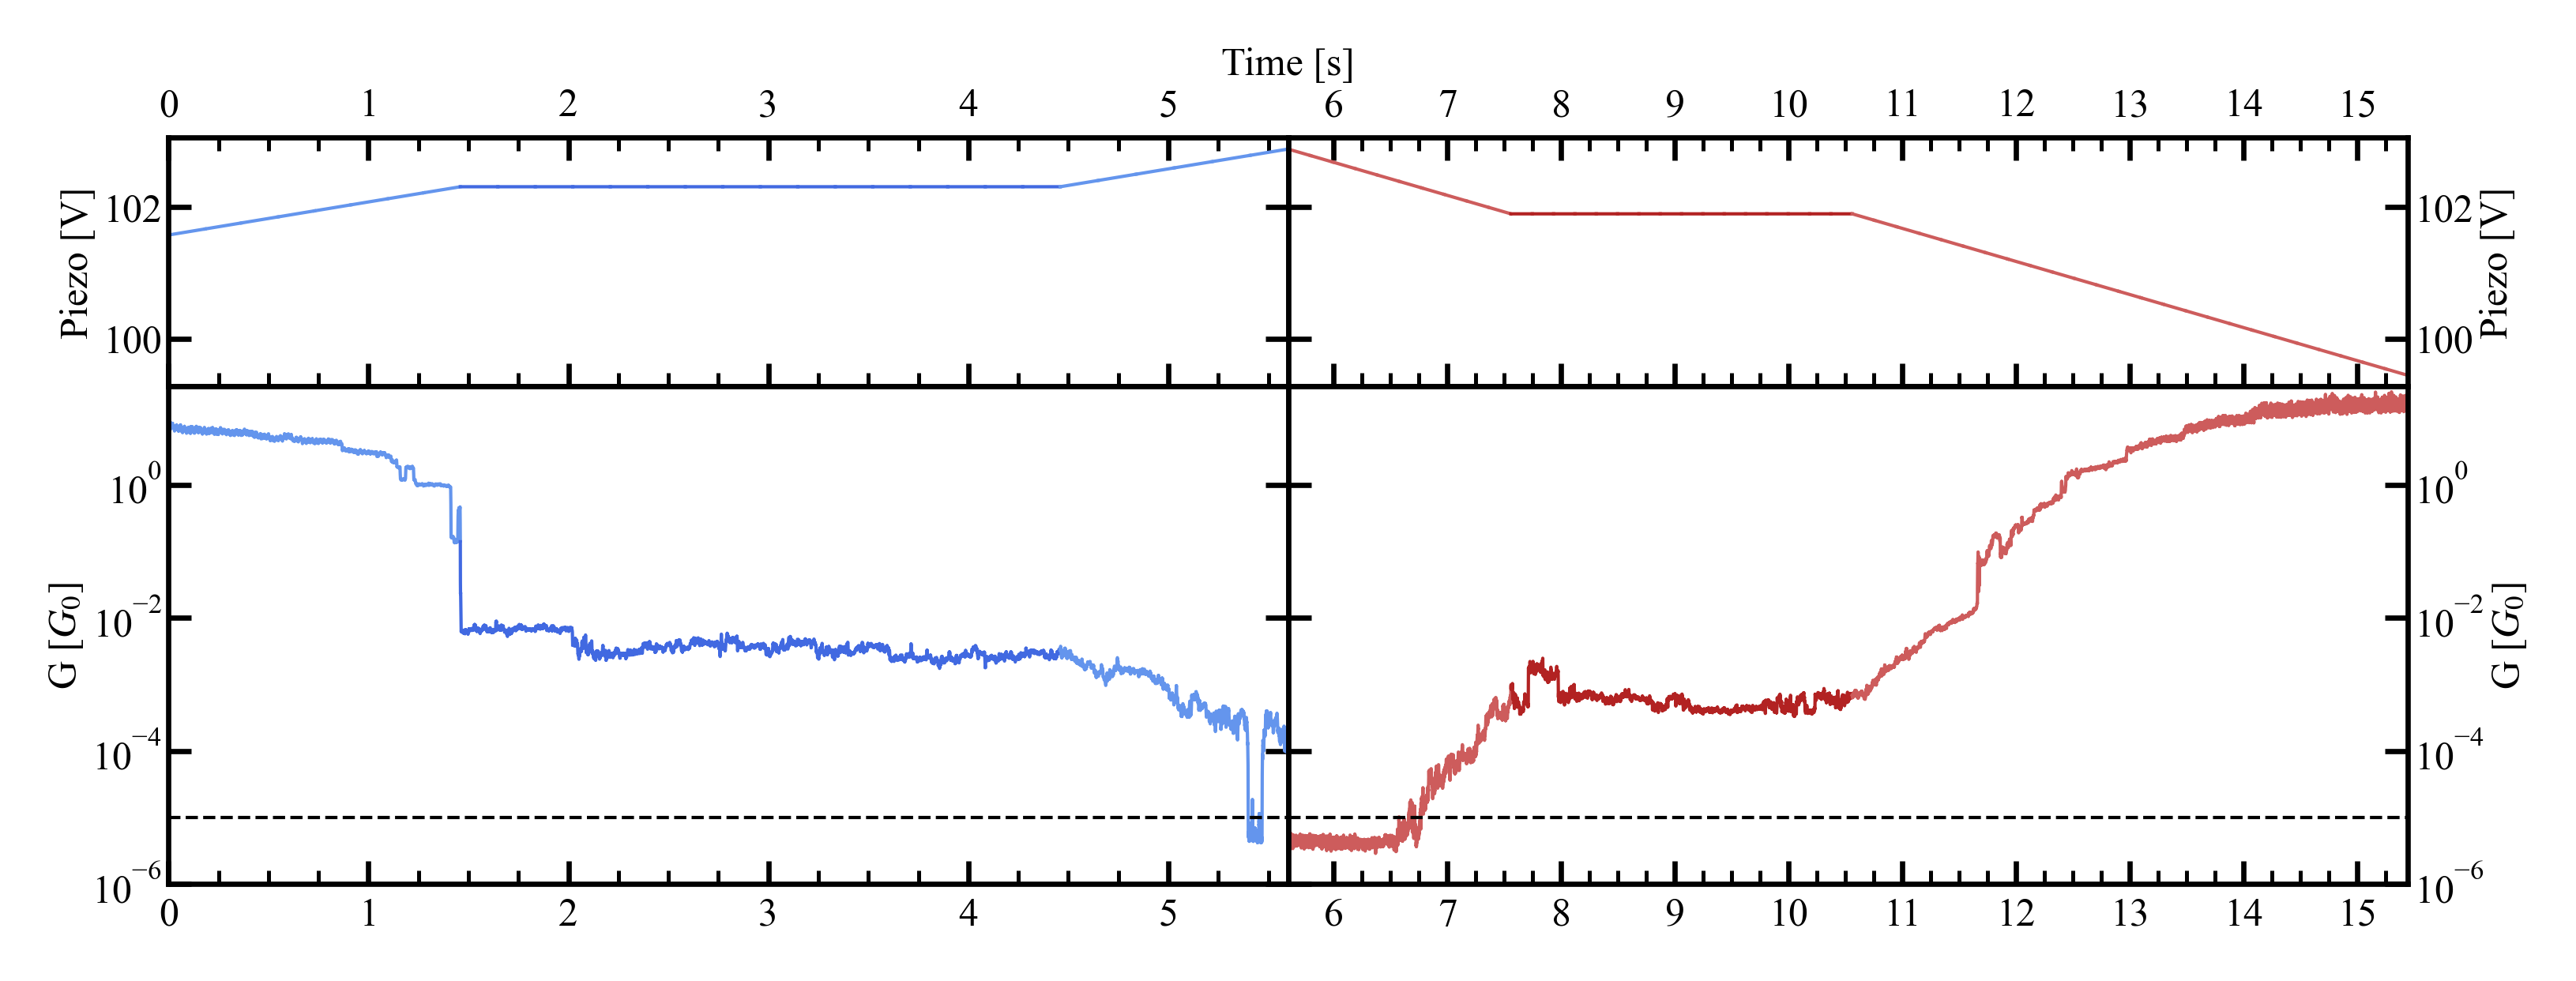

In [11]:
ax_piezo_pull, ax_cond_pull, ax_piezo_push, ax_cond_push = plots.plot_measurement_scheme_combed_both(
    trace_pair=trace_pair,
    hold_trace=hold_trace,
    home_folder=home_folder,
    smoothing=100)

ax_cond_pull.axhline(1e-5, lw=0.5, ls='--', c='k')
ax_cond_push.axhline(1e-5, lw=0.5, ls='--', c='k')

In [12]:
hold_trace.bias_steps_ranges_pull[0]

array([     0, 150000], dtype=int64)

#### num_of_fft = 1

In [13]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_both,
                         num_of_fft=1, subtract_bg=False, min_step_len=100, min_height=100, iv=None,
                         save_data=1)

  0%|          | 0/1730 [00:00<?, ?it/s]

Data saved.


#### num_of_fft = 4

In [14]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_both,
                         num_of_fft=4, subtract_bg=False, min_step_len=100, min_height=100, iv=None,
                         save_data=2)

  0%|          | 0/1730 [00:00<?, ?it/s]

Data saved.


### Filter traces where the conductance does not differ more than a factor of 2

In [15]:
filt_pull, filt_push = filter_traces.filter_hold(folder=home_folder,
                                                 filter_condition=filter_traces.conductances_close,
                                                 max_ratio=2, plateaus=(0, 0),
                                                 traces = filt_both,
                                                 bias_offset=0,
                                                 r_serial_ohm=trace_pair.R_serial,
                                                 min_step_len=100, iv=None)

filt_both = np.intersect1d(filt_pull, filt_push)

  0%|          | 0/1730 [00:00<?, ?it/s]

In [16]:
print('pull:', filt_pull.shape[0])
print('push:', filt_push.shape[0])
print('both:', filt_both.shape[0])

pull: 1730
push: 1730
both: 1730


#### num_of_fft = 1

In [17]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_both,
                         num_of_fft=1, subtract_bg=False, min_step_len=100, min_height=100, iv=None,
                         save_data=3)

  0%|          | 0/1730 [00:00<?, ?it/s]

Data saved.


#### num_of_fft = 4

In [18]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_both,
                         num_of_fft=4, subtract_bg=False, min_step_len=100, min_height=100, iv=None,
                         save_data=4)

  0%|          | 0/1730 [00:00<?, ?it/s]

Data saved.


-------------------------------------------------

###  47602-51600 Filter traces that did not break

In [19]:
filt_pull, filt_push = filter_traces.filter_hold(folder=home_folder,
                                                 filter_condition=filter_traces.does_not_break_array,
                                                 start_trace=47602, end_trace=51600,
                                                 bias_offset=0,
                                                 r_serial_ohm=trace_pair.R_serial,
                                                 min_step_len=100, iv=None)

filt_both = np.intersect1d(filt_pull, filt_push)

  0%|          | 0/3999 [00:00<?, ?it/s]

In [20]:
print('pull:', filt_pull.shape[0])
print('push:', filt_push.shape[0])
print('both:', filt_both.shape[0])

pull: 1771
push: 2123
both: 872


#### num_of_fft = 1

In [22]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_both,
                         num_of_fft=1, subtract_bg=False, min_step_len=100, min_height=100, iv=None,
                         save_data=5)

  0%|          | 0/872 [00:00<?, ?it/s]

Data saved.


#### num_of_fft = 4

In [23]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_both,
                         num_of_fft=4, subtract_bg=False, min_step_len=100, min_height=100, iv=None,
                         save_data=6)

  0%|          | 0/872 [00:00<?, ?it/s]

Data saved.


### Filter traces where the conductance does not differ more than a factor of 2

In [25]:
filt_pull, filt_push = filter_traces.filter_hold(folder=home_folder,
                                                 filter_condition=filter_traces.conductances_close,
                                                 traces=filt_both,
                                                 bias_offset=0,
                                                 r_serial_ohm=trace_pair.R_serial,
                                                 min_step_len=100, iv=None,
                                                 max_ratio=2, plateaus=None,)

filt_both = np.intersect1d(filt_pull, filt_push)

  0%|          | 0/872 [00:00<?, ?it/s]

In [26]:
print('pull:', filt_pull.shape[0])
print('push:', filt_push.shape[0])
print('both:', filt_both.shape[0])

pull: 62
push: 396
both: 29


#### num_of_fft = 1

In [27]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_both,
                         num_of_fft=1, subtract_bg=False, min_step_len=100, min_height=100, iv=None,
                         save_data=7)

  0%|          | 0/29 [00:00<?, ?it/s]

Data saved.


#### num_of_fft = 4

In [28]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_both,
                         num_of_fft=4, subtract_bg=False, min_step_len=100, min_height=100, iv=None,
                         save_data=8)

  0%|          | 0/29 [00:00<?, ?it/s]

Data saved.


----------------------------------------

In [29]:
conductance_stat_pull = pd.concat([pd.read_csv(home_folder.joinpath("results/conductance_stats_pull_1.csv"), skiprows=[1]),
                                  pd.read_csv(home_folder.joinpath("results/conductance_stats_pull_3.csv"), skiprows=[1])], ignore_index=True).astype({'trace_index': int})
conductance_stat_push = pd.concat([pd.read_csv(home_folder.joinpath("results/conductance_stats_push_1.csv"), skiprows=[1]),
                                  pd.read_csv(home_folder.joinpath("results/conductance_stats_push_3.csv"), skiprows=[1])], ignore_index=True).astype({'trace_index': int})

In [30]:
# conductance_stat_pull

In [31]:
# conductance_stat_push

In [32]:
x_mesh, y_mesh, H_pull, H_push = calc_2d_relax_hist(traces=conductance_stat_push.trace_index,
                                                    home_folder=home_folder)

Calculating 2D stability histograms:   0%|          | 0/3460 [00:00<?, ?it/s]

Histograms created from 3460 traces.


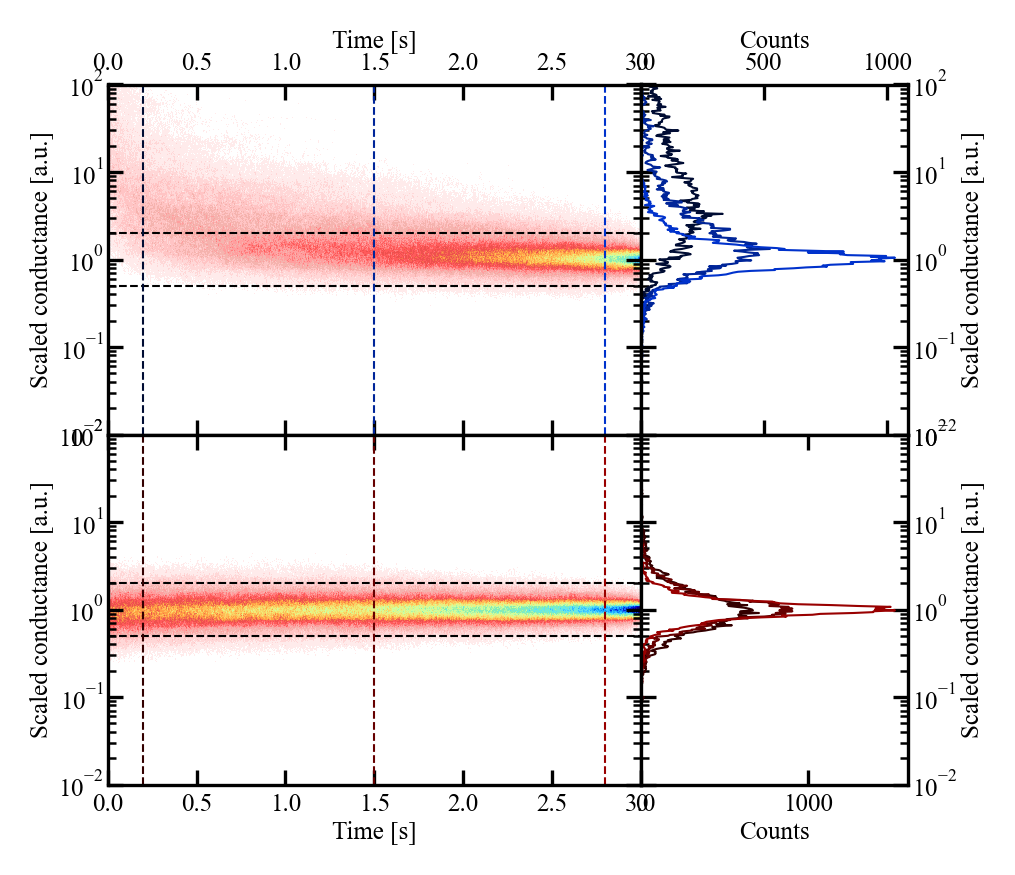

In [33]:
ax_relax_pull, ax_relax_push, ax_hist_pull, ax_hist_push = plot_2d_relax_hist(x_mesh, y_mesh, H_pull, H_push,
                                                                              at_index=(1000, 7500, 14000))

In [34]:
noise_stat_pull = pd.concat([pd.read_csv(home_folder.joinpath("results/noise_stats_pull_1.csv"), skiprows=[1]),
                             pd.read_csv(home_folder.joinpath("results/noise_stats_pull_3.csv"), skiprows=[1])], ignore_index=True).astype({'trace_index': int})
noise_stat_push = pd.concat([pd.read_csv(home_folder.joinpath("results/noise_stats_push_1.csv"), skiprows=[1]),
                             pd.read_csv(home_folder.joinpath("results/noise_stats_push_3.csv"), skiprows=[1])], ignore_index=True).astype({'trace_index': int})

In [35]:
# noise_stat_pull

In [36]:
N = np.linspace(0, 2.2, num=1000)
n_pull= np.zeros(noise_stat_pull['trace_index'].shape[0])        

pull_corr = np.zeros_like(N)
for i, n in enumerate(N):
    pull_corr[i] = utils.calc_correlation(np.log10(noise_stat_pull['noise_power_1']/noise_stat_pull['avg_cond_on_step_1']**n),
                                          np.log10(noise_stat_pull['avg_cond_on_step_1']))

n_pull = N[abs(pull_corr) == min(abs(pull_corr))][0]

n_push= np.zeros(noise_stat_pull['trace_index'].shape[0])        

push_corr = np.zeros_like(N)
for i, n in enumerate(N):
    push_corr[i] = utils.calc_correlation(np.log10(noise_stat_push['noise_power_1']/noise_stat_push['avg_cond_on_step_1']**n),
                                          np.log10(noise_stat_push['avg_cond_on_step_1']))

n_push = N[abs(push_corr) == min(abs(push_corr))][0]

In [37]:
print(n_pull)
print(n_push)

1.83003003003003
1.7155155155155157


(0.0048467398626859, 1.821960877545916)

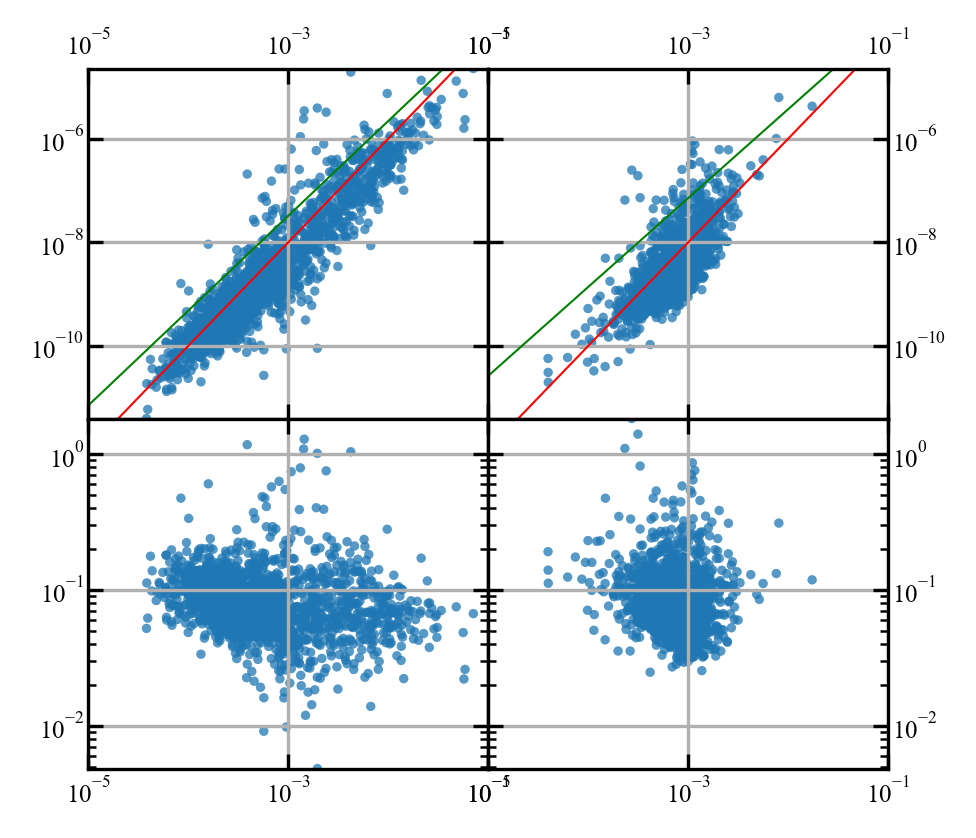

In [38]:
fig = plt.figure(figsize=utils.point2inch(240, 240), dpi=300)  # figsize: (width, height) in inches
gs_total = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=(1, 1), width_ratios=(1, 1),
                             figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.2, wspace=0, hspace=0)

ax_np_pull = fig.add_subplot(gs_total[0, 0])
ax_np_push = fig.add_subplot(gs_total[0, 1])
ax_cn_pull = fig.add_subplot(gs_total[1, 0])
ax_cn_push = fig.add_subplot(gs_total[1, 1])

ax_np_pull.xaxis.tick_top()
ax_np_pull.xaxis.set_label_position('top')
ax_np_pull.xaxis.set_ticks_position('both')
ax_np_pull.yaxis.set_ticks_position('both')

ax_cn_pull.xaxis.set_ticks_position('both')
ax_cn_pull.yaxis.set_ticks_position('both')

ax_np_push.xaxis.tick_top()
ax_np_push.xaxis.set_label_position('top')
ax_np_push.yaxis.tick_right()
ax_np_push.yaxis.set_label_position('right')
ax_np_push.xaxis.set_ticks_position('both')
ax_np_push.yaxis.set_ticks_position('both')

ax_cn_push.yaxis.tick_right()
ax_cn_push.yaxis.set_label_position('right')
ax_cn_push.xaxis.set_ticks_position('both')
ax_cn_push.yaxis.set_ticks_position('both')

ax_np_pull.scatter(noise_stat_pull['avg_cond_on_step_1'], noise_stat_pull['noise_power_1'], s=5, alpha=0.5, edgecolors='none')
ax_np_pull.set_xscale('log')
ax_np_pull.set_yscale('log')
ax_np_pull.grid()

ax_cn_pull.scatter(noise_stat_pull['avg_cond_on_step_1'], noise_stat_pull['conductance_noise_1'], s=5, alpha=0.5, edgecolors='none')
ax_cn_pull.set_xscale('log')
ax_cn_pull.set_yscale('log')
ax_cn_pull.grid()

x = np.logspace(-5, -1, num=50, base=10)
ax_np_pull.plot(x, x**2/100, lw=0.5, c='r')
ax_np_pull.plot(x, x**n_pull/100, lw=0.5, c='g')
ax_np_push.plot(x, x**2/100, lw=0.5, c='r')
ax_np_push.plot(x, x**n_push/100, lw=0.5, c='g')

ax_np_push.scatter(noise_stat_push['avg_cond_on_step_1'], noise_stat_push['noise_power_1'], s=5, alpha=0.5, edgecolors='none')
ax_np_push.set_xscale('log')
ax_np_push.set_yscale('log')
ax_np_push.grid()

ax_cn_push.scatter(noise_stat_push['avg_cond_on_step_1'], noise_stat_push['conductance_noise_1'], s=5, alpha=0.5, edgecolors='none')
ax_cn_push.set_xscale('log')
ax_cn_push.set_yscale('log')
ax_cn_push.grid()

ax_np_pull.set_xlim(1e-5, 1e-1)
ax_np_push.set_xlim(1e-5, 1e-1)
ax_cn_pull.set_xlim(1e-5, 1e-1)
ax_cn_push.set_xlim(1e-5, 1e-1)

ax_np_pull.set_ylim(min(min(noise_stat_pull['noise_power_1']), min(noise_stat_push['noise_power_1'])),
               max(max(noise_stat_pull['noise_power_1']), max(noise_stat_push['noise_power_1'])))

ax_np_push.set_ylim(min(min(noise_stat_pull['noise_power_1']), min(noise_stat_push['noise_power_1'])),
               max(max(noise_stat_pull['noise_power_1']), max(noise_stat_push['noise_power_1'])))

ax_cn_pull.set_ylim(min(min(noise_stat_pull['conductance_noise_1']), min(noise_stat_push['conductance_noise_1'])),
               max(max(noise_stat_pull['conductance_noise_1']), max(noise_stat_push['conductance_noise_1'])))

ax_cn_push.set_ylim(min(min(noise_stat_pull['conductance_noise_1']), min(noise_stat_push['conductance_noise_1'])),
               max(max(noise_stat_pull['conductance_noise_1']), max(noise_stat_push['conductance_noise_1'])))

---------------------------------------------------

## NFFT = 4

In [39]:
noise_stat_pull = pd.concat([pd.read_csv(home_folder.joinpath("results/noise_stats_pull_2.csv"), skiprows=[1]),
                             pd.read_csv(home_folder.joinpath("results/noise_stats_pull_4.csv"), skiprows=[1])], ignore_index=True).astype({'trace_index': int})
noise_stat_push = pd.concat([pd.read_csv(home_folder.joinpath("results/noise_stats_push_2.csv"), skiprows=[1]),
                             pd.read_csv(home_folder.joinpath("results/noise_stats_push_4.csv"), skiprows=[1])], ignore_index=True).astype({'trace_index': int})

In [40]:
noise_stat_pull

,trace_index,avg_cond_on_step_1,avg_current_on_step_1,noise_power_1,conductance_noise_1,current_noise_1
0,40407,0.000805,5.888760e-09,1.046134e-09,0.040200,0.040451
1,40408,0.000304,2.237213e-09,1.613044e-10,0.041711,0.041810
2,40416,0.000448,3.285992e-09,8.572645e-10,0.065396,0.065622
3,40422,0.032119,1.893938e-07,2.484006e-06,0.049070,0.061288
4,40423,0.000743,5.441094e-09,1.828907e-09,0.057554,0.057886
...,...,...,...,...,...,...
3455,43696,0.002341,1.693152e-08,9.728321e-07,0.421381,0.429027
3456,43697,0.000942,6.885830e-09,2.156860e-09,0.049313,0.049673
3457,43698,0.001754,1.274176e-08,7.904564e-09,0.050700,0.051389
3458,43699,0.000559,4.102754e-09,7.896812e-10,0.050226,0.050444


In [41]:
N = np.linspace(0, 2.2, num=1000)
n_pull= np.zeros(noise_stat_pull['trace_index'].shape[0])        

pull_corr = np.zeros_like(N)
for i, n in enumerate(N):
    pull_corr[i] = utils.calc_correlation(np.log10(noise_stat_pull['noise_power_1']/noise_stat_pull['avg_cond_on_step_1']**n),
                                          np.log10(noise_stat_pull['avg_cond_on_step_1']))

n_pull = N[abs(pull_corr) == min(abs(pull_corr))][0]

n_push= np.zeros(noise_stat_pull['trace_index'].shape[0])        

push_corr = np.zeros_like(N)
for i, n in enumerate(N):
    push_corr[i] = utils.calc_correlation(np.log10(noise_stat_push['noise_power_1']/noise_stat_push['avg_cond_on_step_1']**n),
                                          np.log10(noise_stat_push['avg_cond_on_step_1']))

n_push = N[abs(push_corr) == min(abs(push_corr))][0]

In [42]:
print(n_pull)
print(n_push)

1.7573573573573575
1.5503503503503504


(0.0097242914238046, 2.0386077921282597)

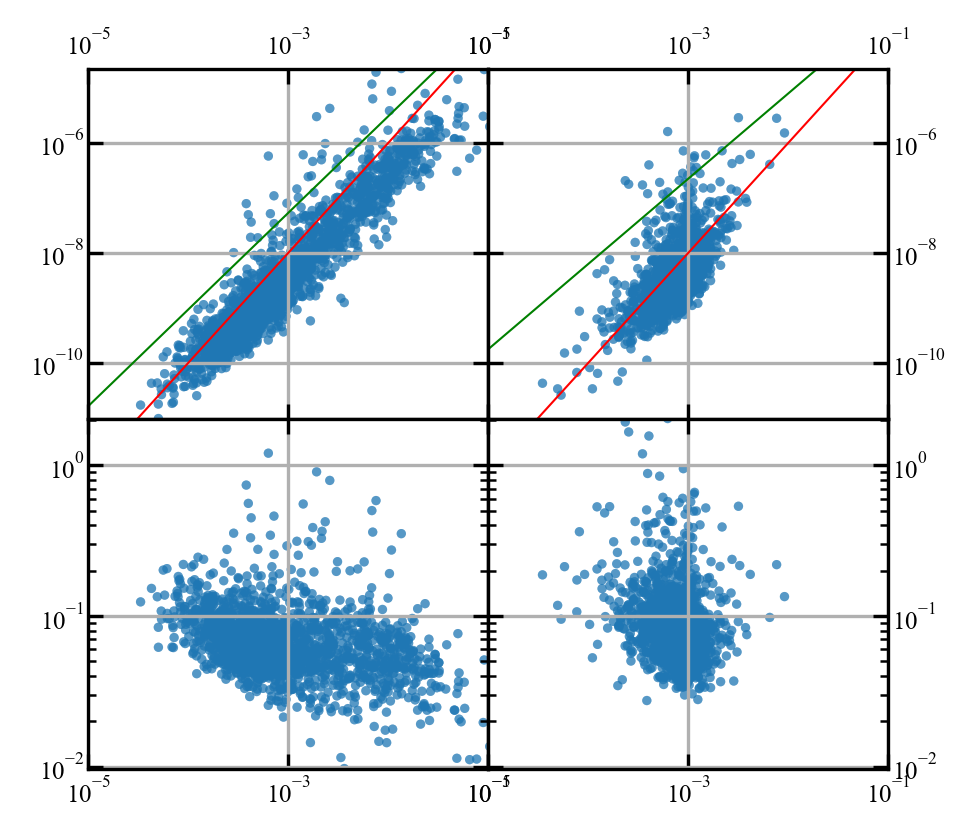

In [43]:
fig = plt.figure(figsize=utils.point2inch(240, 240), dpi=300)  # figsize: (width, height) in inches
gs_total = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=(1, 1), width_ratios=(1, 1),
                             figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.2, wspace=0, hspace=0)

ax_np_pull = fig.add_subplot(gs_total[0, 0])
ax_np_push = fig.add_subplot(gs_total[0, 1])
ax_cn_pull = fig.add_subplot(gs_total[1, 0])
ax_cn_push = fig.add_subplot(gs_total[1, 1])

ax_np_pull.xaxis.tick_top()
ax_np_pull.xaxis.set_label_position('top')
ax_np_pull.xaxis.set_ticks_position('both')
ax_np_pull.yaxis.set_ticks_position('both')

ax_cn_pull.xaxis.set_ticks_position('both')
ax_cn_pull.yaxis.set_ticks_position('both')

ax_np_push.xaxis.tick_top()
ax_np_push.xaxis.set_label_position('top')
ax_np_push.yaxis.tick_right()
ax_np_push.yaxis.set_label_position('right')
ax_np_push.xaxis.set_ticks_position('both')
ax_np_push.yaxis.set_ticks_position('both')

ax_cn_push.yaxis.tick_right()
ax_cn_push.yaxis.set_label_position('right')
ax_cn_push.xaxis.set_ticks_position('both')
ax_cn_push.yaxis.set_ticks_position('both')

ax_np_pull.scatter(noise_stat_pull['avg_cond_on_step_1'], noise_stat_pull['noise_power_1'], s=5, alpha=0.5, edgecolors='none')
ax_np_pull.set_xscale('log')
ax_np_pull.set_yscale('log')
ax_np_pull.grid()

ax_cn_pull.scatter(noise_stat_pull['avg_cond_on_step_1'], noise_stat_pull['conductance_noise_1'], s=5, alpha=0.5, edgecolors='none')
ax_cn_pull.set_xscale('log')
ax_cn_pull.set_yscale('log')
ax_cn_pull.grid()

x = np.logspace(-5, -1, num=50, base=10)
ax_np_pull.plot(x, x**2/100, lw=0.5, c='r')
ax_np_pull.plot(x, x**n_pull/100, lw=0.5, c='g')
ax_np_push.plot(x, x**2/100, lw=0.5, c='r')
ax_np_push.plot(x, x**n_push/100, lw=0.5, c='g')

ax_np_push.scatter(noise_stat_push['avg_cond_on_step_1'], noise_stat_push['noise_power_1'], s=5, alpha=0.5, edgecolors='none')
ax_np_push.set_xscale('log')
ax_np_push.set_yscale('log')
ax_np_push.grid()

ax_cn_push.scatter(noise_stat_push['avg_cond_on_step_1'], noise_stat_push['conductance_noise_1'], s=5, alpha=0.5, edgecolors='none')
ax_cn_push.set_xscale('log')
ax_cn_push.set_yscale('log')
ax_cn_push.grid()

ax_np_pull.set_xlim(1e-5, 1e-1)
ax_np_push.set_xlim(1e-5, 1e-1)
ax_cn_pull.set_xlim(1e-5, 1e-1)
ax_cn_push.set_xlim(1e-5, 1e-1)

ax_np_pull.set_ylim(min(min(noise_stat_pull['noise_power_1']), min(noise_stat_push['noise_power_1'])),
               max(max(noise_stat_pull['noise_power_1']), max(noise_stat_push['noise_power_1'])))

ax_np_push.set_ylim(min(min(noise_stat_pull['noise_power_1']), min(noise_stat_push['noise_power_1'])),
               max(max(noise_stat_pull['noise_power_1']), max(noise_stat_push['noise_power_1'])))

ax_cn_pull.set_ylim(min(min(noise_stat_pull['conductance_noise_1']), min(noise_stat_push['conductance_noise_1'])),
               max(max(noise_stat_pull['conductance_noise_1']), max(noise_stat_push['conductance_noise_1'])))

ax_cn_push.set_ylim(min(min(noise_stat_pull['conductance_noise_1']), min(noise_stat_push['conductance_noise_1'])),
               max(max(noise_stat_pull['conductance_noise_1']), max(noise_stat_push['conductance_noise_1'])))

## Combined I(V)-Noise measurements 

In [44]:
trace_pair = TracePair(70301, load_from=home_folder)
hold_trace = HoldTrace(70301, load_from=home_folder, bias_offset=0, r_serial_ohm=trace_pair.R_serial,
                       sample_rate=trace_pair.sample_rate, min_step_len=9000, min_height=1, iv=0)
hold_trace.analyse_hold_trace(num_of_fft=4, subtract_bg=False, freq_range=(100, 1000))

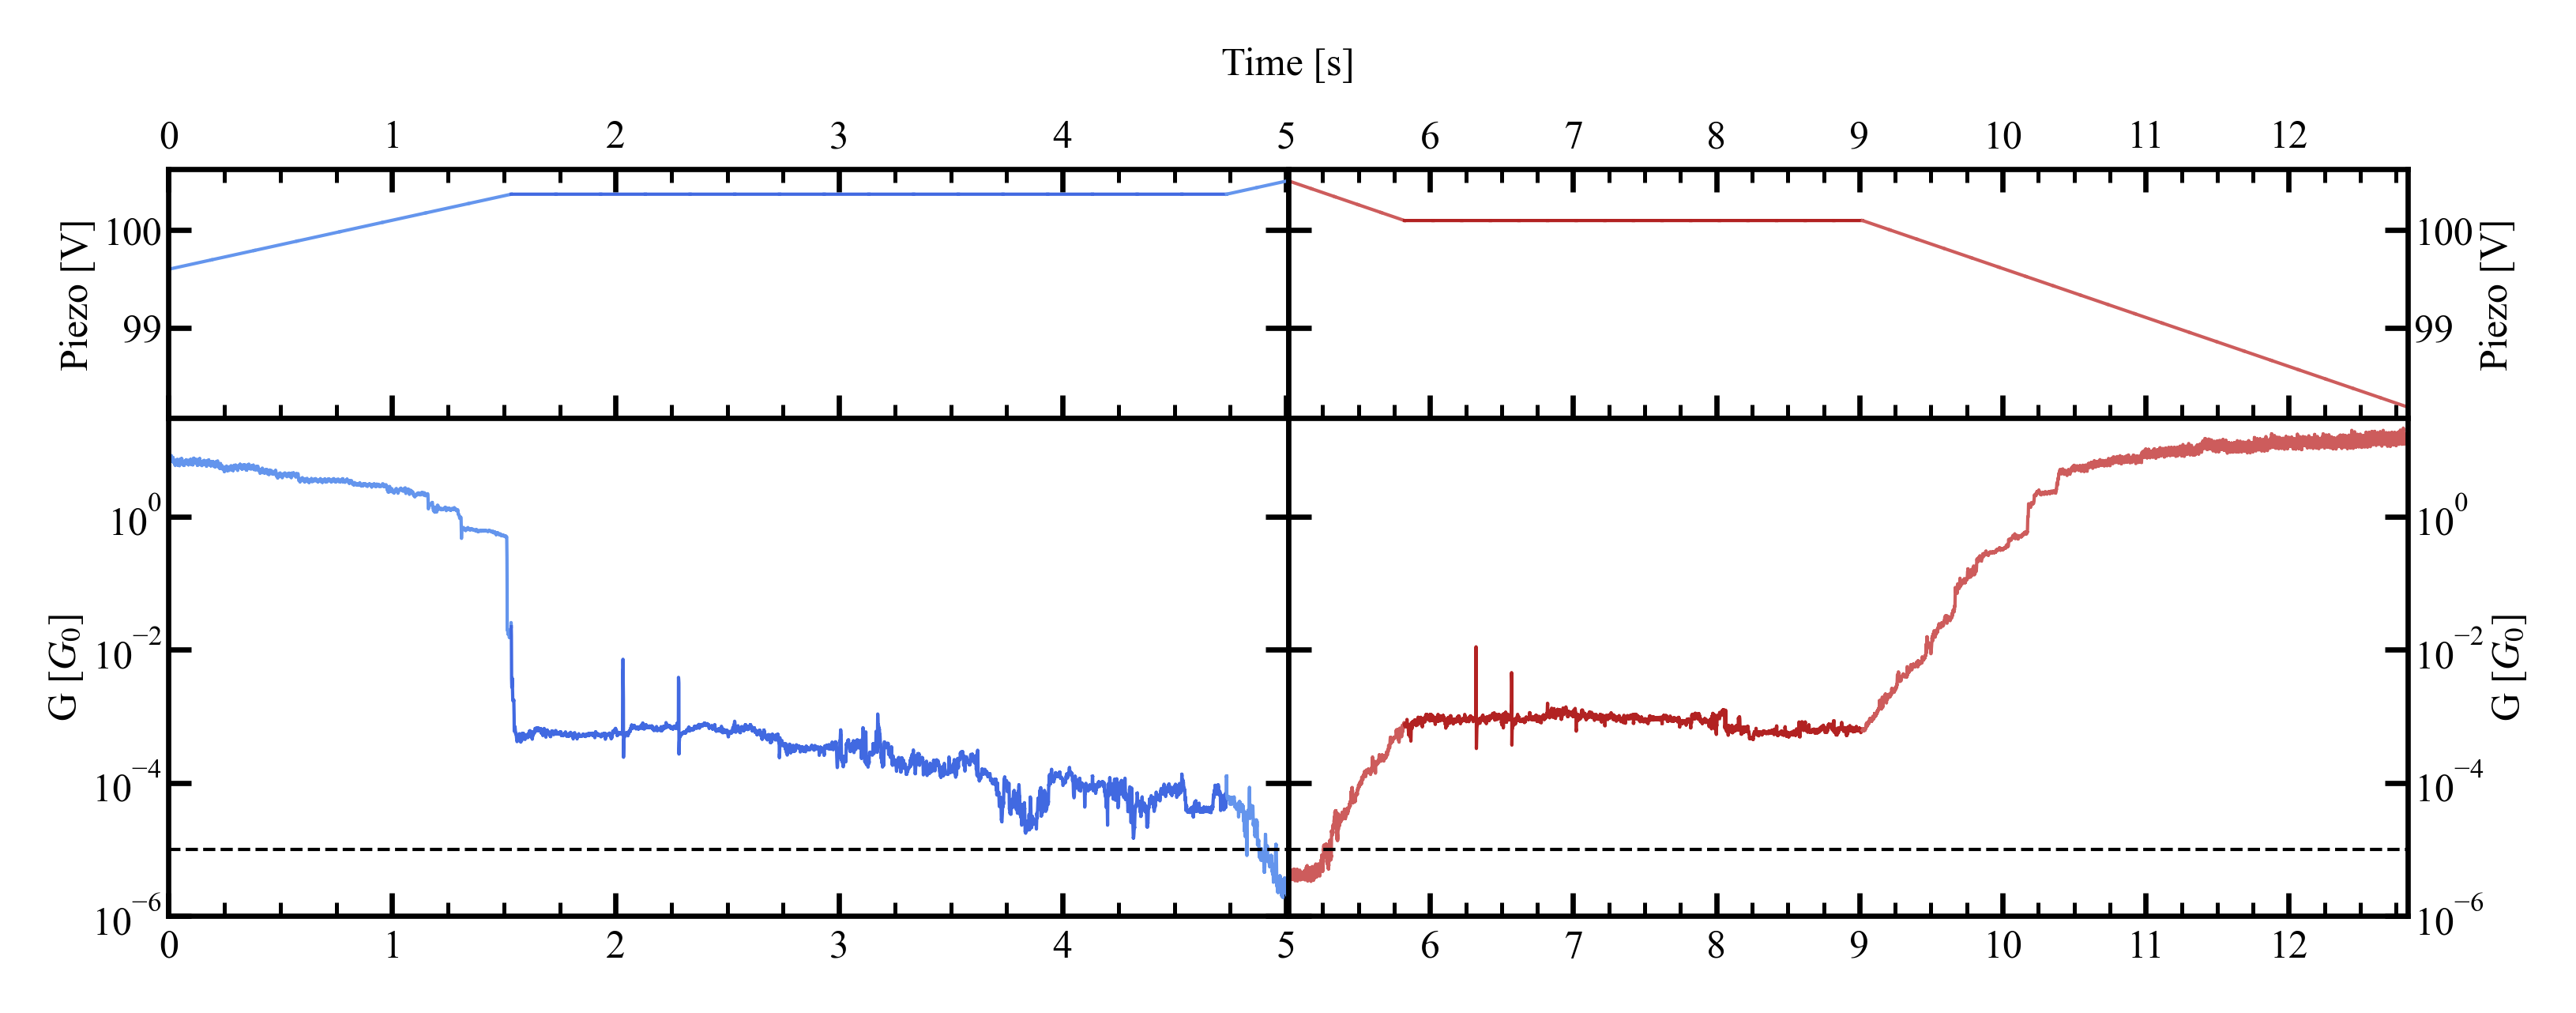

In [45]:
ax_piezo_pull, ax_cond_pull, ax_piezo_push, ax_cond_push = plots.plot_measurement_scheme_combed_both(
    trace_pair=trace_pair,
    hold_trace=hold_trace,
    home_folder=home_folder,
    smoothing=100)

ax_cond_pull.axhline(1e-5, lw=0.5, ls='--', c='k')
ax_cond_push.axhline(1e-5, lw=0.5, ls='--', c='k')

(<AxesSubplot:xlabel='Piezo [V]', ylabel='Conductance [$G_{0}$]'>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Current [$10^{-8}\\;\\mathrm{A}$]'>,
 <AxesSubplot:ylabel='Bias [V]'>,
 <AxesSubplot:xlabel='Bias [V]', ylabel='Current [$10^{-8}\\;\\mathrm{A}$]'>,
 <AxesSubplot:xlabel='Frequency [Hz]', ylabel='$S_{I}\\;[\\mathrm{A}^2/\\mathrm{Hz}]$'>)

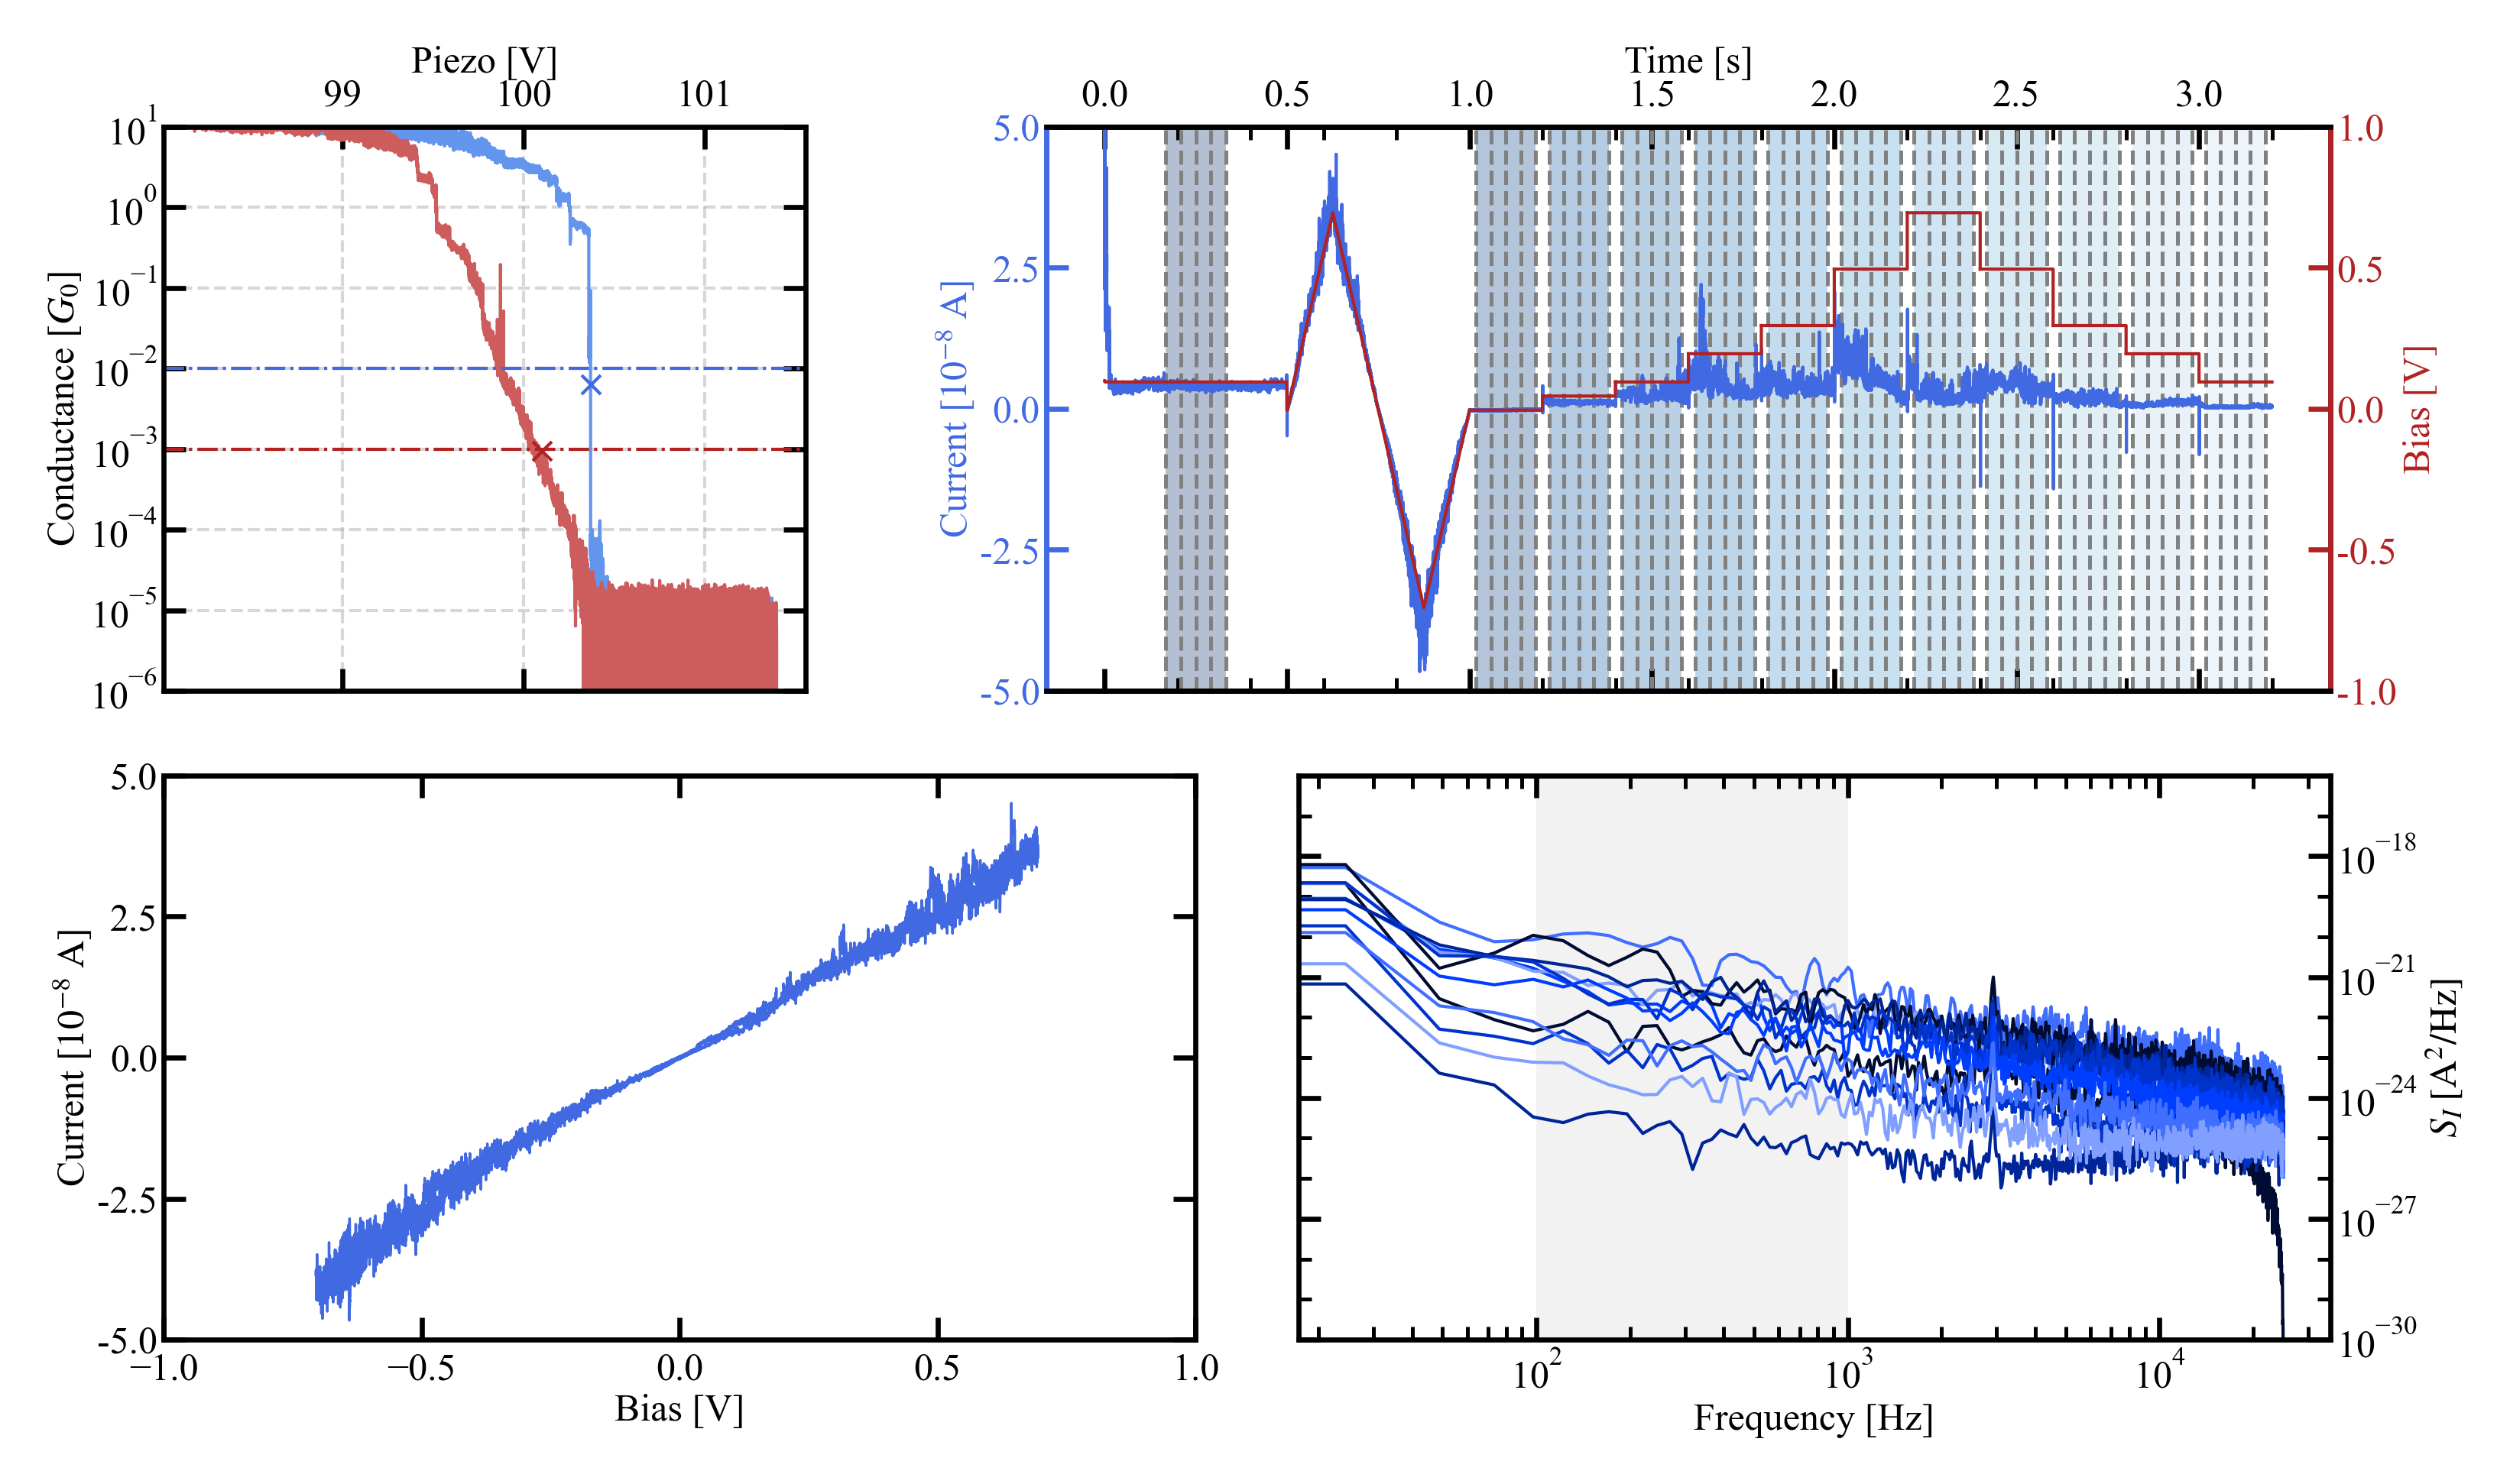

In [46]:
plots.plot_ivs_scheme_one(trace_pair, hold_trace, direction='pull', smoothing=1,
                          color_list=[mpl.colormaps['Blues'](i) for i in np.linspace(1, 0.25, num=12)])

In [47]:
plateaus=(2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
conductances_pull = []
conductances_push = []
    
for i in plateaus:
    conductances_pull.append(np.mean(hold_trace.hold_conductance_pull[
                                     hold_trace.bias_steps_ranges_pull[i][0] + 50:
                                     hold_trace.bias_steps_ranges_pull[i][1] - 50]))

    conductances_push.append(np.mean(hold_trace.hold_conductance_push[
                                     hold_trace.bias_steps_ranges_push[i][0] + 50:
                                     hold_trace.bias_steps_ranges_push[i][1] - 50]))

conductances_pull = np.array(conductances_pull)
conductances_push = np.array(conductances_push)

pull = np.all(abs(np.diff(conductances_pull)/conductances_pull[-1]) < 2)
push = np.all(abs(np.diff(conductances_push) / conductances_push[-1]) < 2)

In [48]:
abs(np.diff(conductances_pull)/conductances_pull[-1])

array([0.1207634 , 1.171402  , 2.0386302 , 0.35718653, 2.1619306 ,
       1.1559736 , 0.6679273 , 0.20491762, 0.24344781], dtype=float32)

### Filtering traces 70201-73500

In [49]:
filt_pull, filt_push = filter_traces.filter_hold(folder=home_folder,
                                                 filter_condition=filter_traces.does_not_break_array,
                                                 start_trace=70201, end_trace=73500,
                                                 bias_offset=0,
                                                 r_serial_ohm=trace_pair.R_serial,
                                                 min_height=1,
                                                 min_step_len=9000, iv=0)

filt_both = np.intersect1d(filt_pull, filt_push)

  0%|          | 0/3300 [00:00<?, ?it/s]

In [50]:
print('pull:', filt_pull.shape[0])
print('push:', filt_push.shape[0])
print('both:', filt_both.shape[0])

pull: 1613
push: 2717
both: 1602


In [51]:
filt_pull, filt_push = filter_traces.filter_hold(folder=home_folder,
                                                 filter_condition=filter_traces.conductances_close,
                                                 traces=filt_both,
                                                 bias_offset=0,
                                                 r_serial_ohm=trace_pair.R_serial,
                                                 min_height=1,
                                                 min_step_len=9000, iv=0,
                                                 max_ratio=2,
                                                 plateaus=(2, 3, 4, 5, 6, 7, 8, 9, 10, 11))

filt_both = np.intersect1d(filt_pull, filt_push)

  0%|          | 0/1602 [00:00<?, ?it/s]

In [52]:
print('pull:', filt_pull.shape[0])
print('push:', filt_push.shape[0])
print('both:', filt_both.shape[0])

pull: 1268
push: 1497
both: 1186


In [53]:
trace_index = np.random.choice(filt_both)
print(trace_index)

trace_pair = TracePair(trace_index, load_from=home_folder)
hold_trace = HoldTrace(trace_index, load_from=home_folder, bias_offset=0, r_serial_ohm=trace_pair.R_serial,
                       sample_rate=trace_pair.sample_rate, min_step_len=9000, min_height=1, iv=0)
hold_trace.analyse_hold_trace(num_of_fft=1, subtract_bg=False, freq_range=(100, 1000))

73142


(<AxesSubplot:xlabel='Piezo [V]', ylabel='Conductance [$G_{0}$]'>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Current [$10^{-8}\\;\\mathrm{A}$]'>,
 <AxesSubplot:ylabel='Bias [V]'>,
 <AxesSubplot:xlabel='Bias [V]', ylabel='Current [$10^{-8}\\;\\mathrm{A}$]'>,
 <AxesSubplot:xlabel='Frequency [Hz]', ylabel='$S_{I}\\;[\\mathrm{A}^2/\\mathrm{Hz}]$'>)

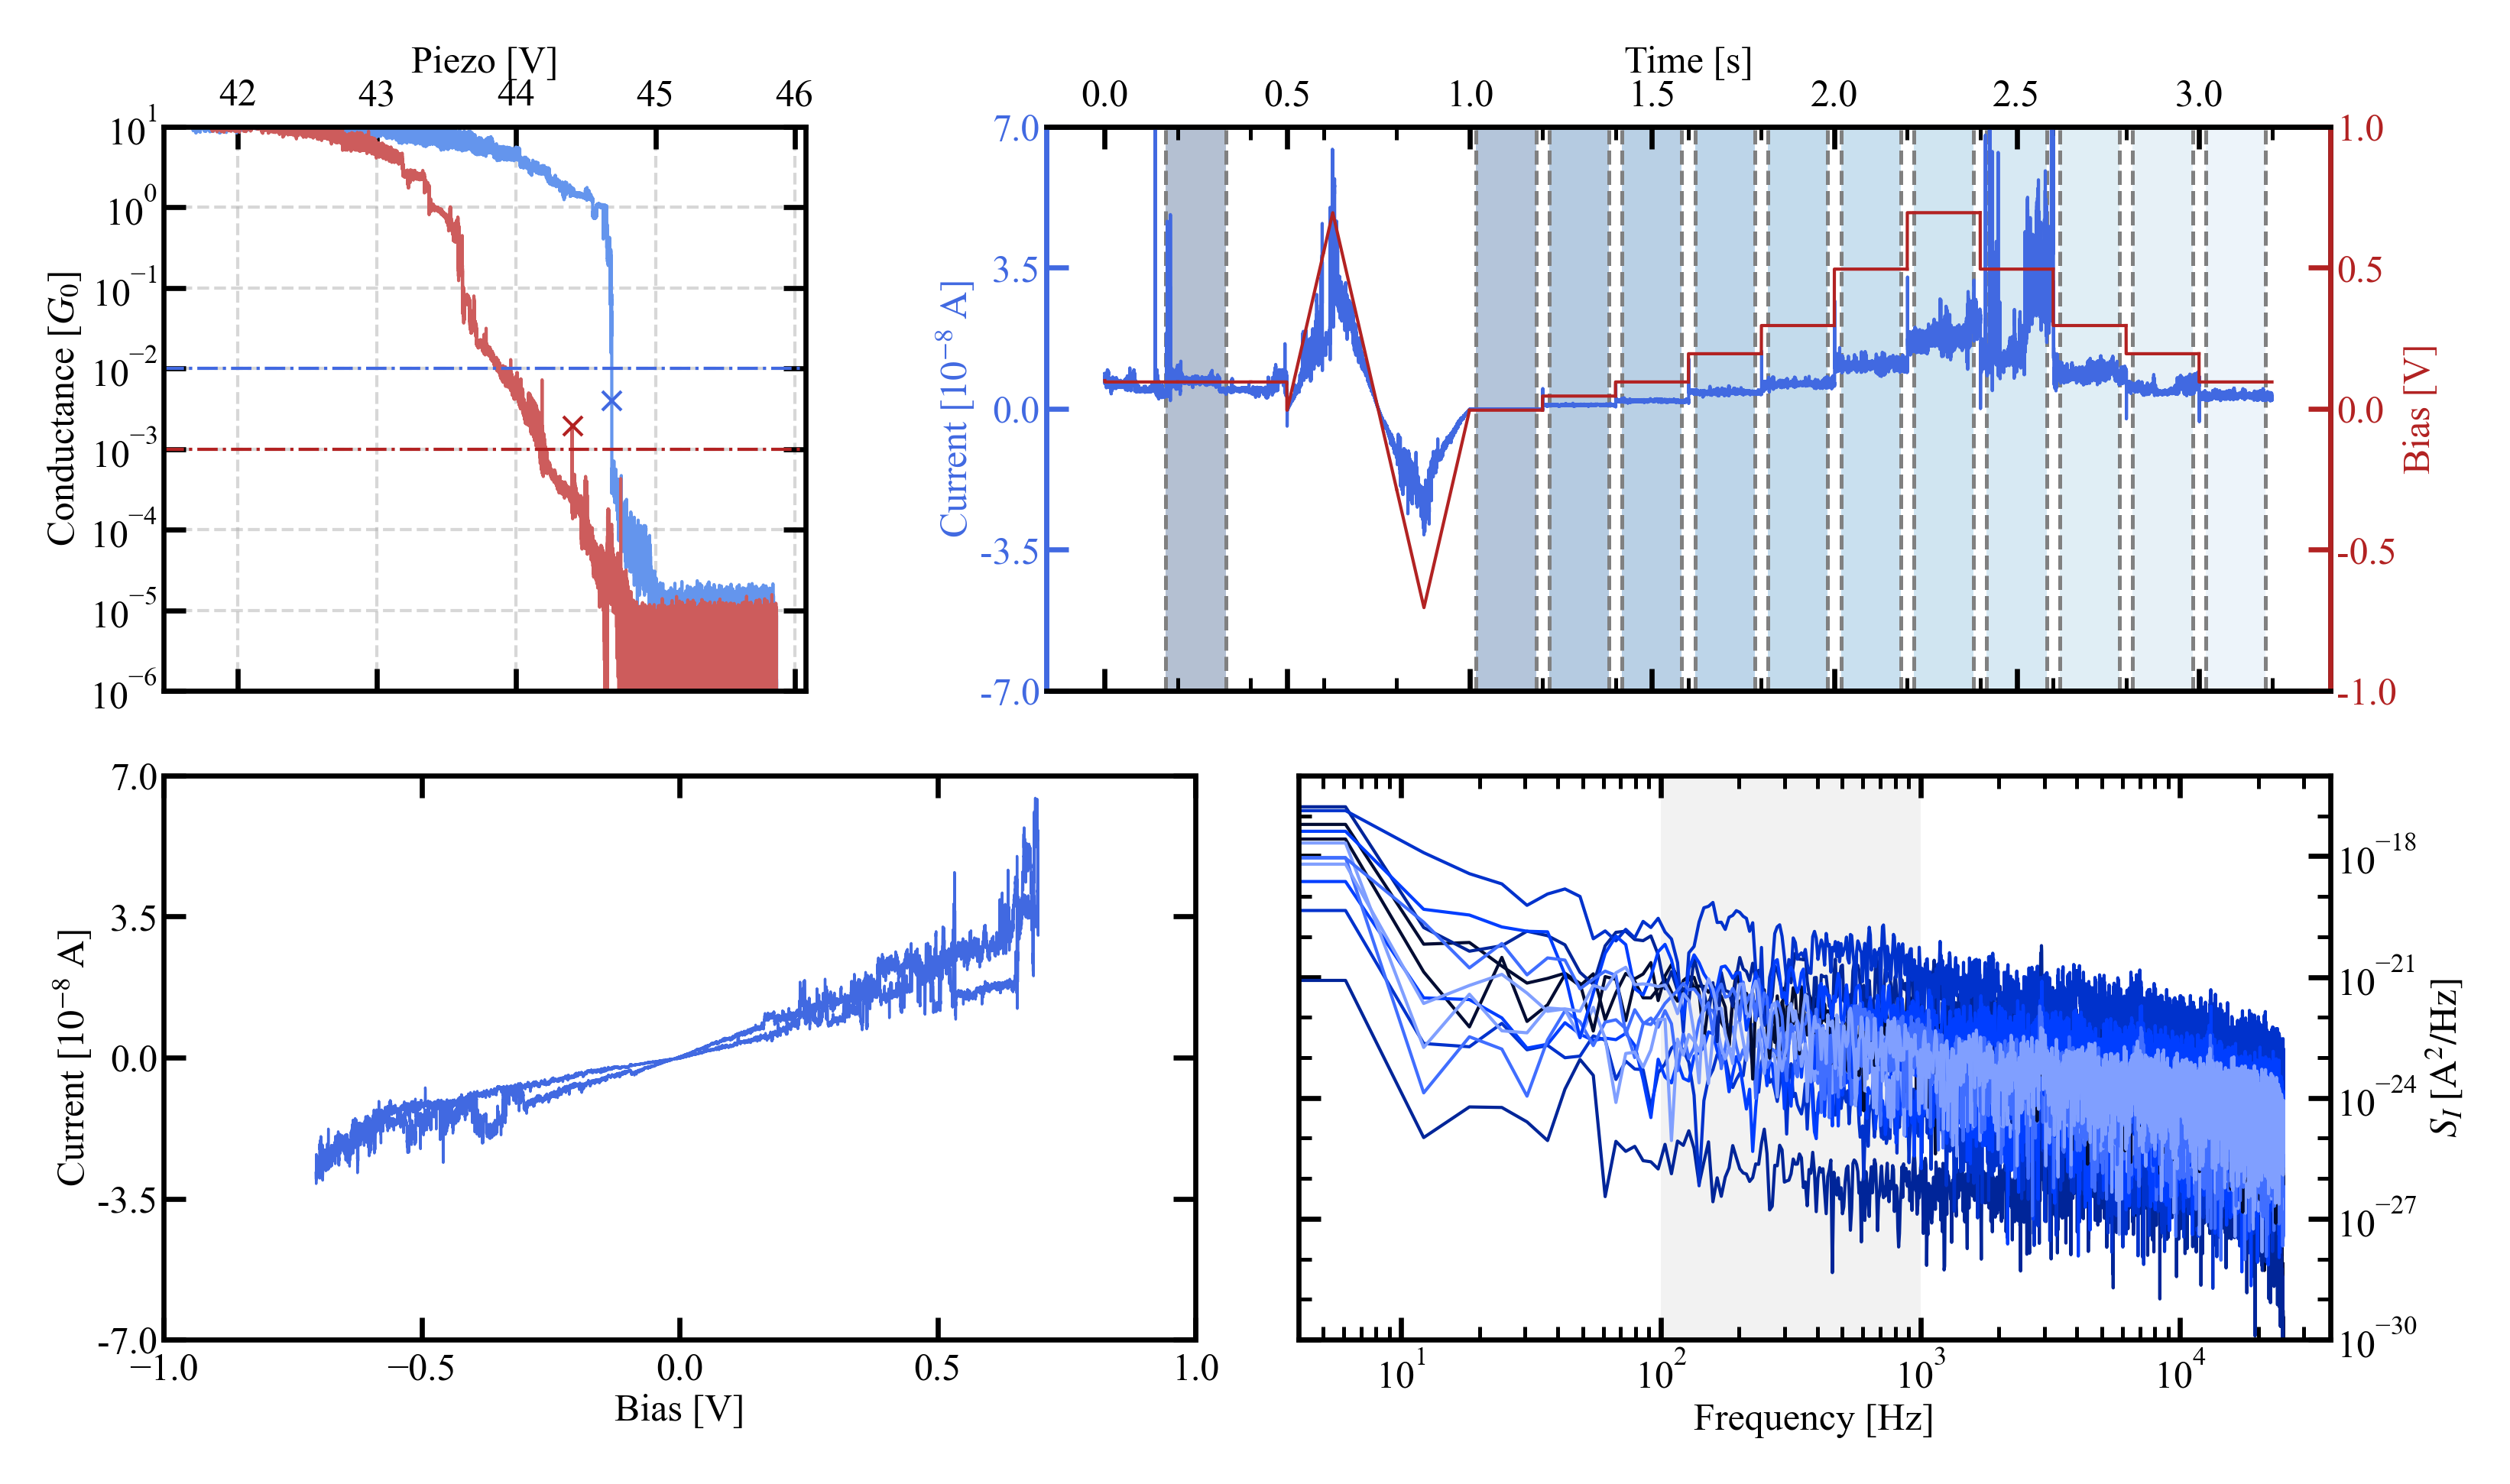

In [54]:
plots.plot_ivs_scheme_one(trace_pair, hold_trace, direction='pull', smoothing=1,
                          color_list=[mpl.colormaps['Blues'](i) for i in np.linspace(1, 0.25, num=12)])

In [55]:
# hold_trace.plot_hold_traces(direction='pull',
#                             plot_step_ranges=False,
#                             plot_psd_intervals=True,
#                             conductance=True, log_scale_y=True,
#                             smoothing=1)

In [56]:
# hold_trace.plot_hold_traces(direction='push',
#                             plot_step_ranges=False,
#                             plot_psd_intervals=True,
#                             conductance=True, log_scale_y=True,
#                             smoothing=1)

In [57]:
for trace_index in tqdm(filt_pull):
    trace_pair = TracePair(trace_index, load_from=home_folder)
    hold_trace = HoldTrace(trace_index, load_from=home_folder, bias_offset=0, r_serial_ohm=trace_pair.R_serial,
                           sample_rate=trace_pair.sample_rate, min_step_len=9000, min_height=1, iv=0)
    hold_trace.analyse_hold_trace(num_of_fft=1, subtract_bg=False, freq_range=(100, 1000))
    hold_trace.save_iv_for_laci(home_folder=home_folder, direction='pull')
    
rename(home_folder.joinpath('results/IVs/selected'), home_folder.joinpath('results/IVs/selected_9'))
    
for trace_index in tqdm(filt_push):
    trace_pair = TracePair(trace_index, load_from=home_folder)
    hold_trace = HoldTrace(trace_index, load_from=home_folder, bias_offset=0, r_serial_ohm=trace_pair.R_serial,
                           sample_rate=trace_pair.sample_rate, min_step_len=9000, min_height=1, iv=0)
    hold_trace.analyse_hold_trace(num_of_fft=1, subtract_bg=False, freq_range=(100, 1000))
    hold_trace.save_iv_for_laci(home_folder=home_folder, direction='push')
    
rename(home_folder.joinpath('results/IVs/selected'), home_folder.joinpath('results/IVs/selected_10'))

  0%|          | 0/1268 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

In [58]:
# noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
#                          traces = filt_pull,
#                          num_of_fft=4, subtract_bg=False, min_step_len=9000, min_height=1, iv=None,
#                          save_data=9)

In [59]:
# noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
#                          traces = filt_push,
#                          num_of_fft=4, subtract_bg=False, min_step_len=9000, min_height=1, iv=None,
#                          save_data=10)

In [60]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_pull,
                         num_of_fft=4, subtract_bg=True, min_step_len=9000, min_height=1, iv=0,
                         save_data=9)

  0%|          | 0/1268 [00:00<?, ?it/s]

D:\Greta\mcbj_stm-bj\mcbj.py:3416: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(multiplier * areas) / avg_value  # unitless
D:\Greta\mcbj_stm-bj\mcbj.py:3419: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.ones_like(multiplier) * areas) / avg_value  # unitless \Delta I/ I


Data saved.


In [61]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_push,
                         num_of_fft=4, subtract_bg=True, min_step_len=9000, min_height=1, iv=0,
                         save_data=10)

  0%|          | 0/1497 [00:00<?, ?it/s]

Data saved.


### Filtering traces 77002-81500

In [62]:
filt_pull, filt_push = filter_traces.filter_hold(folder=home_folder,
                                                 filter_condition=filter_traces.does_not_break_array,
                                                 start_trace=77002, end_trace=81500,
                                                 bias_offset=0,
                                                 r_serial_ohm=trace_pair.R_serial,
                                                 min_height=1,
                                                 min_step_len=9000, iv=0)

filt_both = np.intersect1d(filt_pull, filt_push)

  0%|          | 0/4499 [00:00<?, ?it/s]

D:\Greta\mcbj_stm-bj\utils.py:176: RuntimeWarning: divide by zero encountered in reciprocal
  return 12900 * (bias_v / current - r_serial_ohm) ** (-1)


In [63]:
print('pull:', filt_pull.shape[0])
print('push:', filt_push.shape[0])
print('both:', filt_both.shape[0])

pull: 1781
push: 2493
both: 1079


In [64]:
filt_pull, filt_push = filter_traces.filter_hold(folder=home_folder,
                                                 filter_condition=filter_traces.conductances_close,
                                                 traces=filt_both,
                                                 bias_offset=0,
                                                 r_serial_ohm=trace_pair.R_serial,
                                                 min_height=1,
                                                 min_step_len=9000, iv=0,
                                                 max_ratio=2,
                                                 plateaus=(2, 3, 4, 5, 6, 7, 8, 9, 10, 11))

filt_both = np.intersect1d(filt_pull, filt_push)

  0%|          | 0/1079 [00:00<?, ?it/s]

In [65]:
print('pull:', filt_pull.shape[0])
print('push:', filt_push.shape[0])
print('both:', filt_both.shape[0])

pull: 873
push: 1038
both: 839


In [66]:
for trace_index in tqdm(filt_pull):
    trace_pair = TracePair(trace_index, load_from=home_folder)
    hold_trace = HoldTrace(trace_index, load_from=home_folder, bias_offset=0, r_serial_ohm=trace_pair.R_serial,
                           sample_rate=trace_pair.sample_rate, min_step_len=9000, min_height=1, iv=0)
    hold_trace.analyse_hold_trace(num_of_fft=1, subtract_bg=False, freq_range=(100, 1000))
    hold_trace.save_iv_for_laci(home_folder=home_folder, direction='pull')
    
rename(home_folder.joinpath('results/IVs/selected'), home_folder.joinpath('results/IVs/selected_11'))
    
for trace_index in tqdm(filt_push):
    trace_pair = TracePair(trace_index, load_from=home_folder)
    hold_trace = HoldTrace(trace_index, load_from=home_folder, bias_offset=0, r_serial_ohm=trace_pair.R_serial,
                           sample_rate=trace_pair.sample_rate, min_step_len=9000, min_height=1, iv=0)
    hold_trace.analyse_hold_trace(num_of_fft=1, subtract_bg=False, freq_range=(100, 1000))
    hold_trace.save_iv_for_laci(home_folder=home_folder, direction='push')
    
rename(home_folder.joinpath('results/IVs/selected'), home_folder.joinpath('results/IVs/selected_12'))

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/1038 [00:00<?, ?it/s]

In [67]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_pull,
                         num_of_fft=4, subtract_bg=True, min_step_len=9000, min_height=1, iv=0,
                         save_data=11)

  0%|          | 0/873 [00:00<?, ?it/s]

Data saved.


In [68]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_push,
                         num_of_fft=4, subtract_bg=True, min_step_len=9000, min_height=1, iv=0,
                         save_data=12)

  0%|          | 0/1038 [00:00<?, ?it/s]

Data saved.


### Filtering traces 81501-96200

In [69]:
filt_pull, filt_push = filter_traces.filter_hold(folder=home_folder,
                                                 filter_condition=filter_traces.does_not_break_array,
                                                 start_trace=81501, end_trace=96200,
                                                 bias_offset=0,
                                                 r_serial_ohm=trace_pair.R_serial,
                                                 min_height=1,
                                                 min_step_len=9000, iv=0)

filt_both = np.intersect1d(filt_pull, filt_push)

  0%|          | 0/14700 [00:00<?, ?it/s]

In [70]:
print('pull:', filt_pull.shape[0])
print('push:', filt_push.shape[0])
print('both:', filt_both.shape[0])

pull: 9301
push: 12077
both: 9196


In [71]:
filt_pull, filt_push = filter_traces.filter_hold(folder=home_folder,
                                                 filter_condition=filter_traces.conductances_close,
                                                 traces=filt_both,
                                                 bias_offset=0,
                                                 r_serial_ohm=trace_pair.R_serial,
                                                 min_height=1,
                                                 min_step_len=9000, iv=0,
                                                 max_ratio=2,
                                                 plateaus=(2, 3, 4, 5, 6, 7, 8, 9, 10, 11))

filt_both = np.intersect1d(filt_pull, filt_push)

  0%|          | 0/9196 [00:00<?, ?it/s]

In [72]:
print('pull:', filt_pull.shape[0])
print('push:', filt_push.shape[0])
print('both:', filt_both.shape[0])

pull: 7799
push: 8926
both: 7573


In [73]:
for trace_index in tqdm(filt_pull):
    trace_pair = TracePair(trace_index, load_from=home_folder)
    hold_trace = HoldTrace(trace_index, load_from=home_folder, bias_offset=0, r_serial_ohm=trace_pair.R_serial,
                           sample_rate=trace_pair.sample_rate, min_step_len=9000, min_height=1, iv=0)
    hold_trace.analyse_hold_trace(num_of_fft=1, subtract_bg=False, freq_range=(100, 1000))
    hold_trace.save_iv_for_laci(home_folder=home_folder, direction='pull')
    
rename(home_folder.joinpath('results/IVs/selected'), home_folder.joinpath('results/IVs/selected_13'))
    
for trace_index in tqdm(filt_push):
    trace_pair = TracePair(trace_index, load_from=home_folder)
    hold_trace = HoldTrace(trace_index, load_from=home_folder, bias_offset=0, r_serial_ohm=trace_pair.R_serial,
                           sample_rate=trace_pair.sample_rate, min_step_len=9000, min_height=1, iv=0)
    hold_trace.analyse_hold_trace(num_of_fft=1, subtract_bg=False, freq_range=(100, 1000))
    hold_trace.save_iv_for_laci(home_folder=home_folder, direction='push')
    
rename(home_folder.joinpath('results/IVs/selected'), home_folder.joinpath('results/IVs/selected_14'))

  0%|          | 0/7799 [00:00<?, ?it/s]

  0%|          | 0/8926 [00:00<?, ?it/s]

In [74]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_pull,
                         num_of_fft=4, subtract_bg=True, min_step_len=9000, min_height=1, iv=0,
                         save_data=13)

  0%|          | 0/7799 [00:00<?, ?it/s]

Data saved.


In [75]:
noise_stats = NoiseStats(folder=home_folder, bias_offset=0,
                         traces = filt_push,
                         num_of_fft=4, subtract_bg=True, min_step_len=9000, min_height=1, iv=0,
                         save_data=14)

  0%|          | 0/8926 [00:00<?, ?it/s]

Data saved.
